In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from adjustText import adjust_text
import matplotlib.patheffects as path_effects

In [2]:
# information about relations
characters = pd.read_csv("dane/characters.csv")
relations = pd.read_csv("dane/relations.csv")

# information about being a mojor character
dialogues = pd.read_csv("dane/Dialogue.csv", encoding='ISO-8859-1')
character_for_dialogue = pd.read_csv("dane/Characters_for_dialogues.csv", encoding='ISO-8859-1')

In [3]:
graph_df = relations.merge(
    characters.loc[:, ["id", "name"]],
    how = "left",
    left_on = "source",
    right_on= "id"
)

In [4]:
graph_df = graph_df.merge(
    characters.loc[:, ["id", "name"]],
    how = "left",
    left_on = "target",
    right_on= "id"
)

In [5]:
graph_df["positive_relation"] = (graph_df["type"] == "+")

In [6]:
graph_df = graph_df.loc[:, ["source", "target", "positive_relation"]]

In [7]:
graph = nx.from_pandas_edgelist(graph_df, edge_attr="positive_relation")

In [8]:
nodes_names = characters.set_index("id")["name"].to_dict()

In [9]:
graph = nx.relabel_nodes(graph, nodes_names, copy=False)

In [10]:
dialogues_count = dialogues.groupby("Character ID").aggregate("count").loc[:, "Dialogue"].reset_index()

In [11]:
dialogues_count.columns = ["Character ID", "Dialogue count"]

In [12]:
dialogues_df = dialogues_count.merge(
    character_for_dialogue,
    on = "Character ID",
    how = "left"
).loc[:, ["Character Name", "Dialogue count"]]

In [13]:
node_size = dialogues_df.set_index("Character Name")["Dialogue count"].to_dict()

In [14]:
got_graph = nx.from_pandas_edgelist(graph_df, "source", "target")

In [15]:
pos = nx.kamada_kawai_layout(got_graph)

In [16]:
node_size = np.array([node_size.get(n, 0.5) for n in graph.nodes()])

In [17]:
graph_df = relations.merge(
    characters.loc[:, ["id", "name"]],
    how = "left",
    left_on = "source",
    right_on= "id"
)
graph_df = graph_df.merge(
    characters.loc[:, ["id", "name"]],
    how = "left",
    left_on = "target",
    right_on= "id"
)

In [18]:
test = pd.DataFrame([(nodes_names[x], nodes_names[y]) for (x, y) in got_graph.edges])

In [19]:
test.columns = ["name_x", "name_y"]

In [20]:
test = test.merge(
    graph_df,
    left_on = ["name_x", "name_y"],
    right_on = ["name_x", "name_y"],
    how = "left"
)

In [21]:
test = test.merge(
    graph_df,
    left_on = ["name_y", "name_x"],
    right_on = ["name_x", "name_y"],
    how = "left"
)

In [22]:
test["new"] = False

In [23]:
test.loc[test["type_x"] == "+","new"] = True

In [24]:
test.loc[test["type_y"] == "+","new"] = True

In [25]:
test = test["new"]

In [26]:
colors = np.where(test, "green", "red")

In [27]:
colour_dict = dict()

In [28]:
for index, row in graph_df.iterrows():
    colour_dict[(row["name_x"], row["name_y"])] = "green" if row["type"] == "+" else "red"
    colour_dict[(row["name_y"], row["name_x"])] = "green" if row["type"] == "+" else "red"

In [29]:
sorted_edges = sorted(got_graph.edges(data=True), key=lambda x: (x[0], x[1]))

In [30]:
colors = [colour_dict[(nodes_names[x], nodes_names[y])] for (x, y, *c) in sorted_edges]

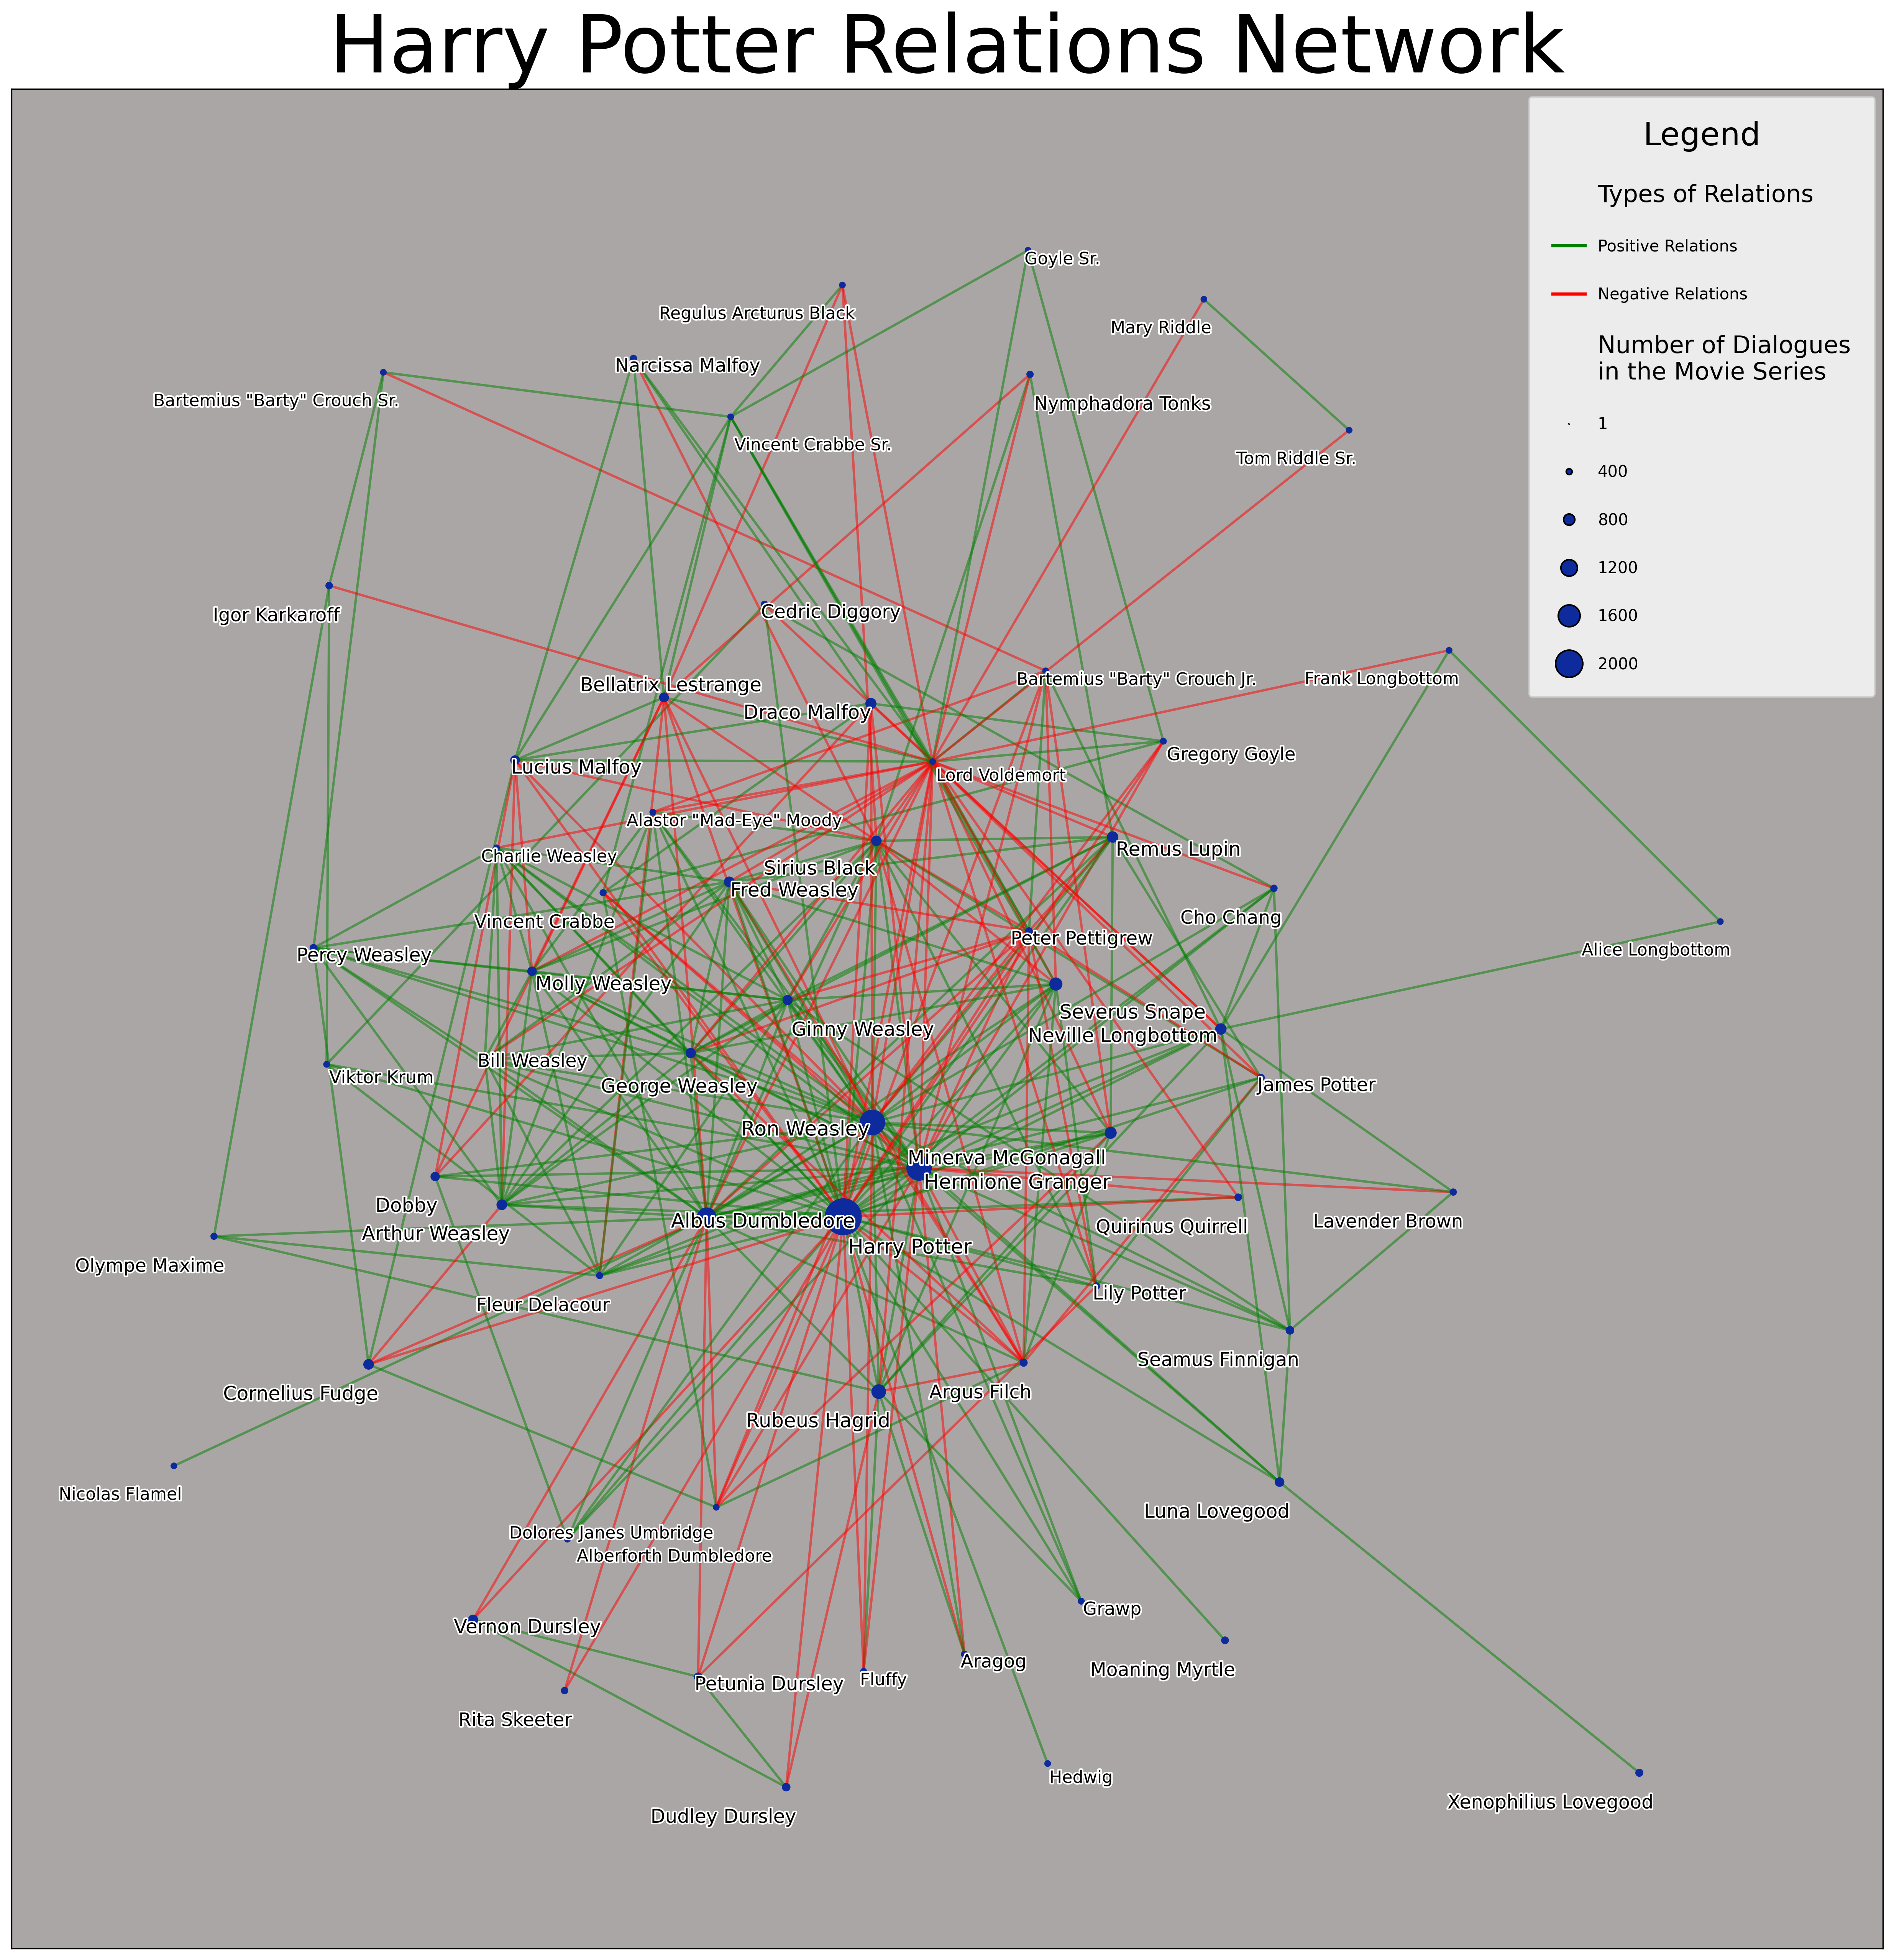

In [31]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import matplotlib.patheffects as path_effects
from adjustText import adjust_text

fig, ax = plt.subplots(1, 1, figsize=(21, 21), dpi=300)

# Drawing layers for better control (e.g. different transparency levels)
ax.set_title("Harry Potter Relations Network", fontsize=50)

nx.draw_networkx_nodes(
    got_graph, 
    pos=pos, 
    node_color="#0e2b9e", 
    node_size=node_size/4 + 10, 
    ax=ax
)

nx.draw_networkx_edges(
    got_graph,
    pos=pos,
    edgelist=sorted_edges,
    edge_color=colors,
    width=1.5,
    alpha=0.5,  
    ax=ax,
)

texts = []

for i, (node, (x, y)) in enumerate(pos.items()):
    text = ax.text(
        x, 
        y - 0.02, 
        nodes_names[node], 
        fontsize=10 + np.sqrt(np.log(node_size[i] + 1)), 
        ha="center", 
        va="center", 
        color="black"  
    )

    text.set_path_effects([
        path_effects.Stroke(linewidth=2, foreground='white'), 
        path_effects.Normal()  
    ])
    texts.append(text)

adjust_text(texts, ax=ax)

legend_elements = [
    plt.Line2D([0], [0], color='none', label=f'Types of Relations'),
    plt.Line2D([0], [0], color='green', lw=2, label='Positive Relations'),
    plt.Line2D([0], [0], color='red', lw=2, label='Negative Relations'),
    plt.Line2D([0], [0], color='none', label="Number of Dialogues\nin the Movie Series")
]

size_legend = [
    plt.Line2D([0], [0], marker='o', color="none", markerfacecolor='#0e2b9e', markersize=(10 + s / 4) / 30, label=f"{s or 1}")
    for s in range(0, 2001, 400)
]

legend = ax.legend(
    handles=legend_elements + size_legend, 
    title="Legend", 
    loc="upper right", 
    labelspacing=2,
    borderpad=1.5,
    title_fontsize=20,
)

ax.set_facecolor(color="#aba6a6")

for label in legend.get_texts():
    if label.get_text() == "Types of Relations":
        label.set_fontsize(15)  
    elif label.get_text() == "Number of Dialogues\nin the Movie Series":
        label.set_fontsize(15)

plt.savefig('harry_potter_network.png')
plt.show()